### Multi-Layer Perceptron (MLP)
This notebook extends `209 project.ipynb` by implementing MLP neural network for our classification task. We first imported all necessary packages:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

Then using the preprocessed dataset, we splitted it into training and test sets.

In [2]:
df = pd.read_csv("data/dataset-whole.csv",index_col=0)
num_cols = ['danceability','energy','loudness','speechiness','acousticness',
            'instrumentalness','liveness','valence','tempo','duration_ms',
            'time_signature','chorus_hit','sections']

predictor_ls = num_cols + ['mode','decade','key']

np.random.seed(209)
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=209,
    shuffle=True,
)
X_train = df_train.drop(columns=['target'])
y_train = df_train['target']
X_test = df_test.drop(columns=['target'])
y_test = df_test['target']

We obtained standardized datasets using `StandardScaler()` for `X_train` and `X_test`.

In [3]:
scalerX = StandardScaler().fit(X_train[num_cols])
X_train_std = pd.DataFrame(np.hstack((scalerX.transform(X_train[num_cols]), X_train[['mode', 'decade', 'key']])), columns = predictor_ls) 
X_test_std = pd.DataFrame(np.hstack((scalerX.transform(X_test[num_cols]), X_test[['mode', 'decade', 'key']])), columns = predictor_ls) 

As a baseline approach, we attempted the following parameters for `MLPClassifier` to get an initial result of confusion matrix, loss vs iteration graph, and classification report.

In [16]:
# baseline approach

mlp_clf = MLPClassifier(hidden_layer_sizes=(5,2),
                        max_iter = 300, activation = 'relu',
                        solver = 'adam', random_state = 123)
mlp_clf.fit(X_train_std, y_train)

cv_score = cross_val_score(mlp_clf, X_train_std, y_train, cv = 10)
print('The accuracy score of 10-fold cross validation for {} is {} +/- {}'.format('MLP baseline',
                                                                                np.round(np.mean(cv_score), 3),
                                                                                np.round(np.std(cv_score), 3)))
print('The test accuracy score for {} is {}'.format('MLP baseline',
                                                    np.round(mlp_clf.score(X_test_std, y_test), 3)))

The accuracy score of 10-fold cross validation for MLP baseline is 0.768 +/- 0.008
The test accuracy score for MLP baseline is 0.776


In [17]:
y_pred = mlp_clf.predict(X_test_std)
print("Classification report for MLP baseline: \n", classification_report(y_test, y_pred))

Classification report for MLP baseline: 
               precision    recall  f1-score   support

           0       0.83      0.68      0.75      4039
           1       0.74      0.87      0.80      4183

    accuracy                           0.78      8222
   macro avg       0.79      0.77      0.77      8222
weighted avg       0.78      0.78      0.77      8222



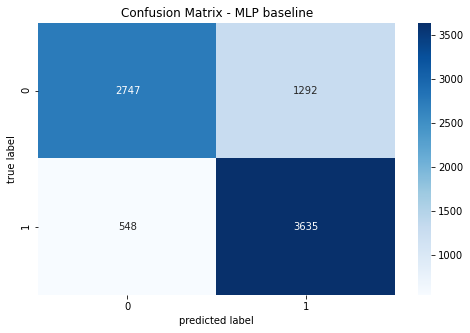

In [18]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (8,5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=True)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Confusion Matrix - MLP baseline')
plt.show()

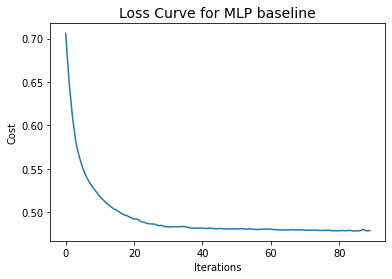

In [25]:
plt.plot(mlp_clf.loss_curve_)
plt.title("Loss Curve for MLP baseline", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

To perform hyperparameter tuning, we used `GridSearchCV` to find the best parameters for `MLPClassifier`.

In [20]:
param_grid = {
    'hidden_layer_sizes': [(200, 120, 50, 10), (150, 80, 40), (100, 50, 30), (50, 20, 5)],
    'max_iter': [50, 100, 200],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.01, 0.05],
    'learning_rate': ['constant','adaptive'],
}

grid = GridSearchCV(mlp_clf, param_grid, n_jobs=-1, cv=5, verbose=10)
grid.fit(X_train_std, y_train)

print(grid.best_params_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 26.3min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 28.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 30.9min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 32.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 34

{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (150, 80, 40), 'learning_rate': 'constant', 'max_iter': 100, 'solver': 'adam'}


In [21]:
# best parameters

mlp_best = MLPClassifier(hidden_layer_sizes=(150, 80, 40), alpha = 0.05,
                        max_iter = 100, activation = 'tanh', learning_rate='constant',
                        solver = 'adam', random_state = 123)
mlp_best.fit(X_train_std, y_train)

cv_score = cross_val_score(mlp_best, X_train_std, y_train, cv = 10)
print('The accuracy score of 10-fold cross validation for {} is {} +/- {}'.format('MLP with best params',
                                                                                np.round(np.mean(cv_score), 3),
                                                                                np.round(np.std(cv_score), 3)))
print('The test accuracy score for {} is {}'.format('MLP with best params',
                                                    np.round(mlp_best.score(X_test_std, y_test), 3)))

The accuracy score of 10-fold cross validation for MLP with best params is 0.796 +/- 0.005
The test accuracy score for MLP with best params is 0.799


In [22]:
y_pred = mlp_best.predict(X_test_std)
print("Classification report for MLP with best params: \n", classification_report(y_test, y_pred))

Classification report for MLP with best params: 
               precision    recall  f1-score   support

           0       0.80      0.79      0.79      4039
           1       0.80      0.81      0.80      4183

    accuracy                           0.80      8222
   macro avg       0.80      0.80      0.80      8222
weighted avg       0.80      0.80      0.80      8222



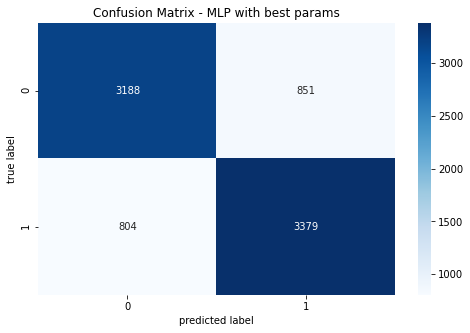

In [23]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (8,5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=True)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Confusion Matrix - MLP with best params')
plt.show()

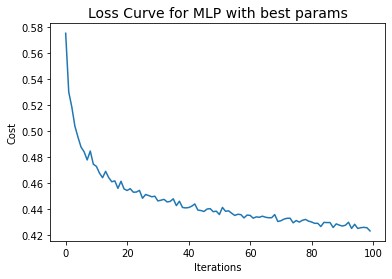

In [26]:
plt.plot(mlp_best.loss_curve_)
plt.title("Loss Curve for MLP with best params", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()